In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [34]:
df = pd.read_csv('data/SPX_25yr_data.csv')
changes_df = pd.DataFrame(df['Date'][1:])
pct_change = [100 * (df['Adj Close'][i+1] / df['Adj Close'][i] - 1) for i in range(df['Adj Close'].size - 1)]
changes_df.insert(1, column='Pct Change', value=pct_change)

In [35]:
from datetime import datetime
import ephem

In [36]:
moon = ephem.Moon()
moon_illumination = []
for day in changes_df['Date']:
    moon.compute(datetime.fromisoformat(day))
    moon_illumination.append(moon.phase)

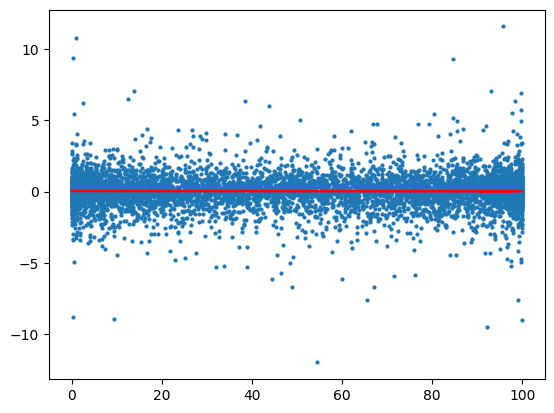

In [37]:
moon_brightness_df = changes_df.copy()
moon_brightness_df.insert(2, column='Moon Brightness %', value=moon_illumination)

x = np.array(moon_brightness_df['Moon Brightness %'])
y = np.array(moon_brightness_df['Pct Change'])
linreg_result = stats.linregress(x, y)
m, c, r, p, m_stderr = linreg_result
plt.plot(x, m*x + c, color='r')
plt.scatter(x, y, s=4)

In [38]:
binary = ['not', '']
print(f'Relationship {binary[float(p)<=0.05]} statistically significant at the p=0.05 level (p={p})')

Relationship not statistically significant at the p=0.05 level (p=0.7951415452808424)


In [39]:
moon_illumination_2 = []
for day in changes_df['Date']:
    days_from_full = datetime.fromisoformat(day) - ephem.previous_full_moon(day).datetime()
    moon_illumination_2.append(days_from_full.days)

In [40]:
changes_df_2 = changes_df.copy()
changes_df_2.insert(2, column='Days since full moon', value=moon_illumination_2)

In [41]:
averages = []
for i in range(30):
    moon_phase_info = changes_df_2[changes_df_2['Days since full moon'] == i]['Pct Change']
    avg = sum(moon_phase_info) / moon_phase_info.size
    averages.append(avg)

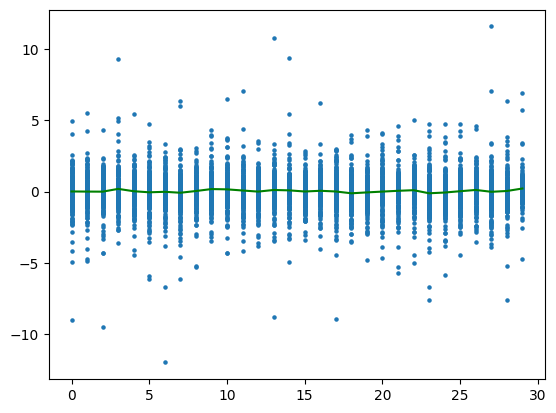

In [42]:
plt.scatter(x=moon_illumination_2, y=changes_df['Pct Change'], s=5)
plt.plot(averages, c='g')

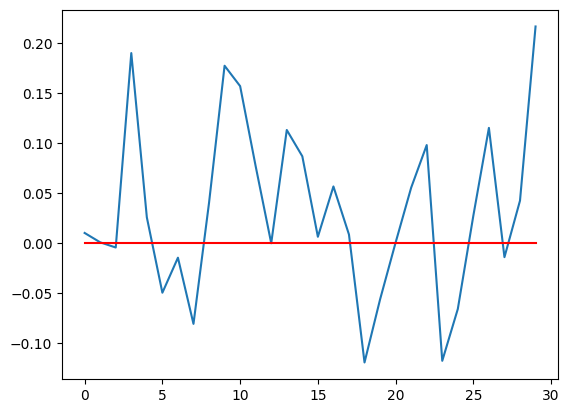

In [43]:
plt.plot(averages)
plt.plot([0 for i in range(30)], c='r')

In [44]:
mean_change = sum(pct_change)/len(pct_change)

In [76]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-08-23,1336.609985,1360.239990,1336.609985,1360.219971,1360.219971,682600000
1,1999-08-24,1360.219971,1373.319946,1353.630005,1363.500000,1363.500000,732700000
2,1999-08-25,1363.500000,1382.839966,1359.199951,1381.790039,1381.790039,864600000
3,1999-08-26,1381.790039,1381.790039,1361.530029,1362.010010,1362.010010,719000000
4,1999-08-27,1362.010010,1365.630005,1347.349976,1348.270020,1348.270020,570050000
...,...,...,...,...,...,...,...
6285,2024-08-15,5501.129883,5546.229980,5501.129883,5543.220215,5543.220215,3723310000
6286,2024-08-16,5530.500000,5561.979980,5525.169922,5554.250000,5554.250000,3357690000
6287,2024-08-19,5557.229980,5608.299805,5550.740234,5608.250000,5608.250000,3222050000
6288,2024-08-20,5602.879883,5620.509766,5585.500000,5597.120117,5597.120117,2994420000


In [105]:
if changes_df_2[changes_df_2['Date'].isin(['2010-01-08'])].empty:
    print('h')

In [98]:
from datetime import timedelta

In [219]:
def moon_strat(start_date, end_date, capital, buy_phase, sell_phase):
    '''Invest all capital into stock when the moon is in buy_phase and sell all when moon is in sell_phase.
    Cap daily pnl at +- 3.5% to smooth variance. (??? todo)\n
    Phases: full moon = 0, waning gibbous = 1, ... , waxing gibbous = 7'''
    phases = [{*range(int(i*3.75 + 0.5) - 2, int(i*3.75 + 4.25) - 2)} for i in range(8)]
    phases[0] = {28, 29, 0, 1}
    
    # get start idx
    while changes_df_2[changes_df_2['Date'].isin([start_date])].empty:
        new_start_date_raw = datetime.strptime(start_date, r'%Y-%m-%d') + timedelta(days=1)
        start_date = new_start_date_raw.strftime(r'%Y-%m-%d')
    time = changes_df_2[changes_df_2['Date'].isin([start_date])].index[0]
    while changes_df_2['Days since full moon'][time] not in phases[buy_phase]:
        time += 1

    # get end idx
    while changes_df_2[changes_df_2['Date'].isin([end_date])].empty:
        new_end_date_raw = datetime.strptime(end_date, r'%Y-%m-%d') - timedelta(days=1)
        end_date = new_end_date_raw.strftime(r'%Y-%m-%d')
    end_idx = changes_df_2[changes_df_2['Date'].isin([end_date])].index[0]
    
    # uncomment this section if you want to force sell at the end
    # while changes_df_2['Days since full moon'][end_idx] not in phases[sell_phase]:
    #     end_idx -= 1
    # while changes_df_2['Days since full moon'][end_idx] in phases[sell_phase]:
    #     end_idx += 1
    
    buy = True
    sell = False
    inventory = 0.0
    stock_prices = []
    while time < end_idx:
        days_since_full = changes_df_2['Days since full moon'][time]
        if buy:
            # spend equal amount of money per day in buy period
            if days_since_full in phases[buy_phase]:
                stock_prices.append(df['Close'][time])
                time += 1
            else:
                for price in stock_prices:
                    money_spent = capital / len(stock_prices)
                    inventory += money_spent / price
                capital = 0
                stock_prices = []
                buy = False
        elif sell:
            # sell equal # of stocks per day
            if days_since_full in phases[sell_phase]:
                stock_prices.append(df['Close'][time])
                time += 1
            else:
                for price in stock_prices:
                    stocks_sold = inventory / len(stock_prices)
                    capital += stocks_sold * price
                inventory = 0
                stock_prices = []
                sell = False
        else:
            if days_since_full in phases[buy_phase]: buy = True
            elif days_since_full in phases[sell_phase]: sell = True
            else:
                time += 1
    return capital + inventory * df['Close'][end_idx]

In [193]:
# moon_strat(start_date='2010-01-01', end_date='2011-01-01', capital=1000, buy_phase=0, sell_phase=4)
year = 2003
start_date = str(year) + '-01-01'
end_date = str(year+20) + '-01-01'

for sell_phase in range(8):
    toPrint = [' '*(5 - len((a := str(round(moon_strat(start_date, end_date, 1000, buy_phase, sell_phase)))))) + a for buy_phase in range(8)]
    print(' '.join(toPrint))

 4425  3095  3172  1645  1022  1030  1145  1356
 1449  4434  4543  2332  1404  1463  1791  1956
 1376   952  4505  2237  1298  1398  1667  1768
 2660  1861  2021  4467  2643  2754  3482  3634
 4267  3000  3262  1620  4213  4441  5937  5871
 4186  2848  2996  1538   974  4163  5652  5569
 3712  2293  2478  1200   722   753  4123  4507
 3243  2204  2374  1158   731   762   928  4264


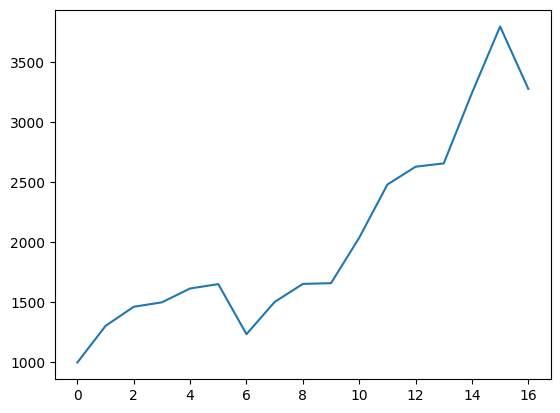

In [217]:

plt.plot([moon_strat('2003-01-01', str(i)+'-01-01', 1000, 2, 1) for i in range(2003, 2020)])

In [229]:
start_year, end_year = 2003, 2019
annual_portfolio = [1000]
while start_year != end_year:
    start_date = str(year) + '-01-01'
    end_date = str(year+1) + '-01-01'
    old_value = annual_portfolio[-1]
    new_value = moon_strat(start_date, end_date, old_value, 0, 1)
    annual_portfolio.append(new_value)
    start_year += 1

In [240]:
# moon_strat(start_date='2010-01-01', end_date='2011-01-01', capital=1000, buy_phase=0, sell_phase=4)

start_date = str(2003) + '-01-01'
end_date = str(2020) + '-01-01'

for sell_phase in range(8):
    toPrint = [' '*(5 - len((a := str(round(moon_strat(start_date, end_date, 1000, buy_phase, sell_phase)))))) + a for buy_phase in range(8)]
    print(' '.join(toPrint))

 3583  2430  2665  1531   981   942  1104  1175
 1501  3677  4012  2283  1417  1407  1728  1782
 1364   931  3812  2095  1254  1287  1534  1540
 2374  1639  1844  3775  2298  2283  2791  2852
 3678  2552  2874  1568  3555  3555  4447  4450
 3785  2541  2769  1562  1018  3503  4437  4427
 3199  2049  2301  1265   810   803  3483  3520
 3037  2008  2315  1251   814   809  1008  3502


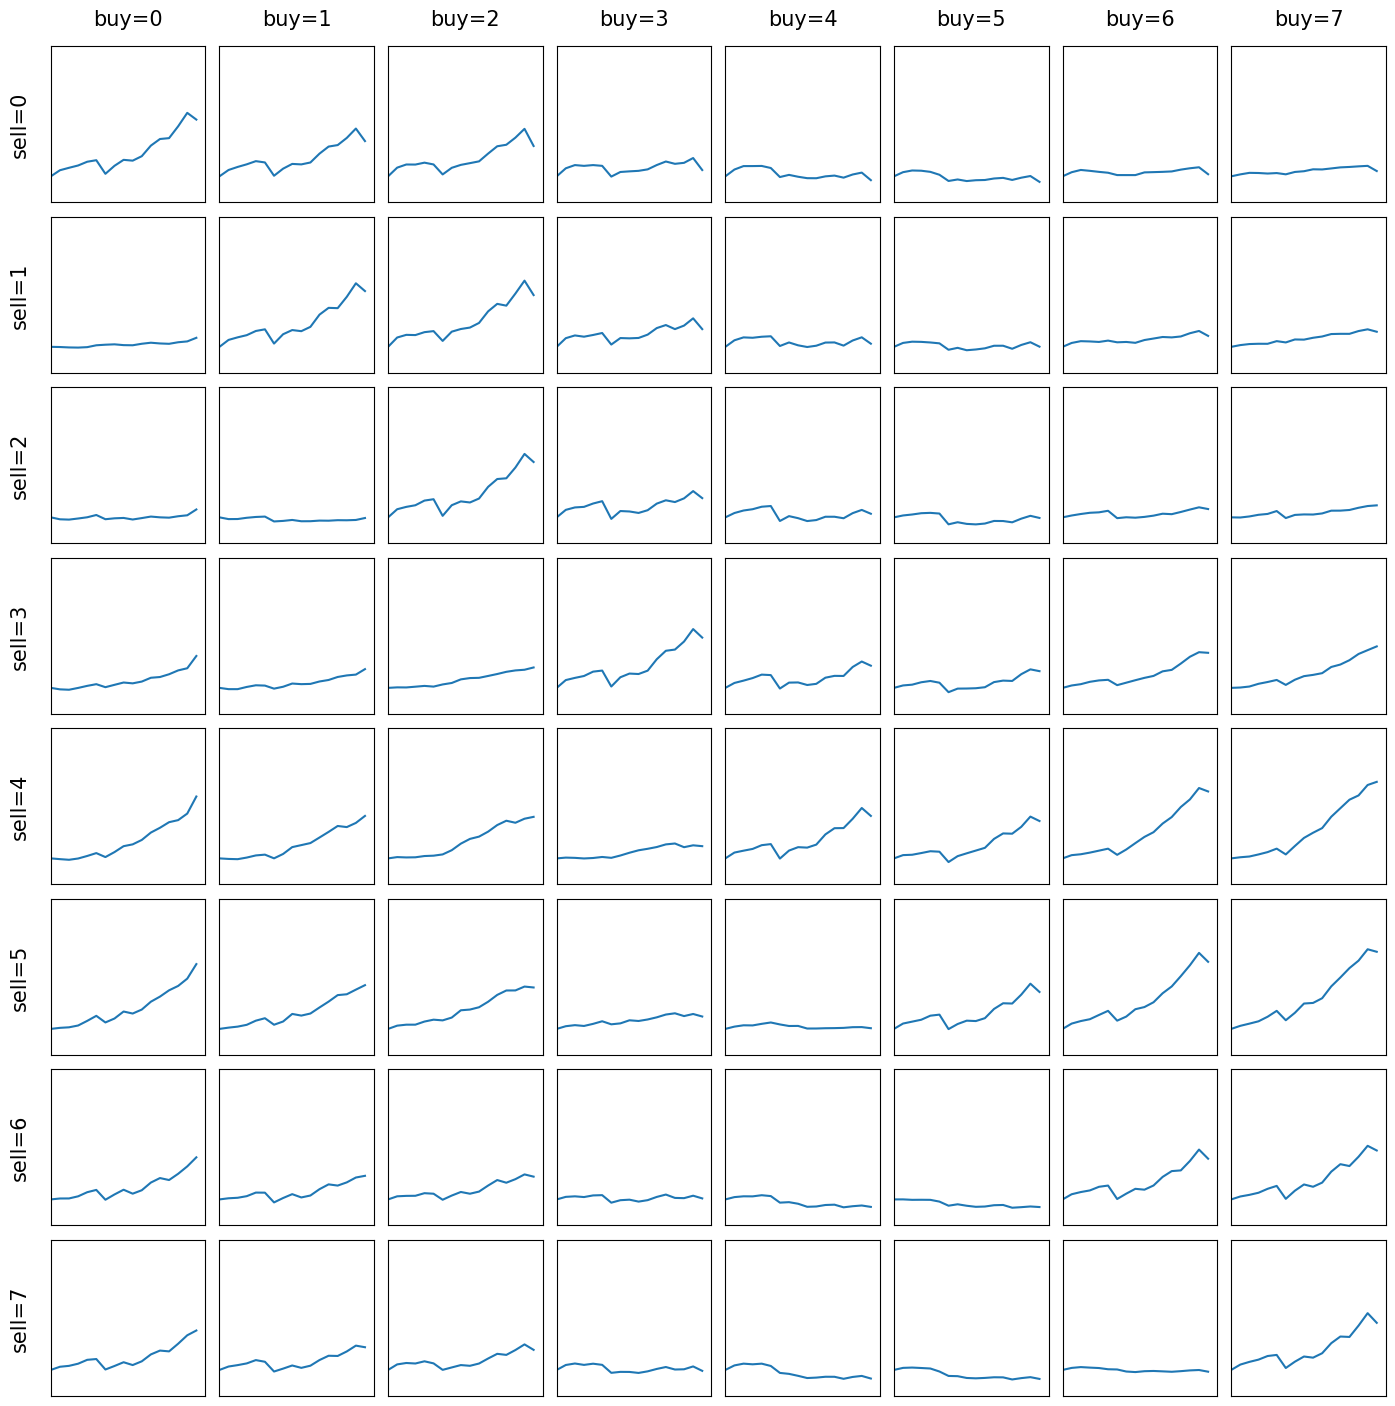

In [254]:
moon_phase_buy = np.arange(8)  # Replace with your 8 x1 values
moon_phase_sell = np.arange(8)  # Replace with your 8 x2 values

# Create an 8x8 grid of subplots
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

# Loop over x1 and x2 values
for i, phase_sell in enumerate(moon_phase_buy):
    for j, phase_buy in enumerate(moon_phase_sell):
        ax = axes[i, j]

        start_year, end_year = 2003, 2019
        annual_portfolio = [1000]
        until = start_year
        while until != end_year:
            start_date = str(until) + '-01-01'
            end_date = str(until+1) + '-01-01'
            old_value = annual_portfolio[-1]
            new_value = moon_strat(start_date, end_date, old_value, phase_buy, phase_sell)
            annual_portfolio.append(new_value)
            until += 1
        
        # Example plot: Replace with your actual plotting logic
        ax.plot(annual_portfolio)
        ax.set_xlim([0, len(annual_portfolio)])
        ax.set_ylim([0, 6000])
        
        # Only set labels on the edges of the grid
        if j == 0:
            ax.set_ylabel(f'sell={phase_sell}', rotation=90, labelpad=15, fontsize=15, ha='center')
        if i == 0:
            ax.set_title(f'buy={phase_buy}', fontsize=15, pad=15)

        # Hide ticks to clean up the plot
        ax.set_xticks([])
        ax.set_yticks([])

# Adjust layout to avoid overlap
plt.tight_layout()

# Adjust the space between the plots for better label visibility
plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05)

# Show the plot
plt.show()

In [294]:
phase_mappings = {0: 'Full Moon',
                  1: 'Waning Gibbous',
                  2: 'Third Quarter',
                  3: 'Waning Crescent',
                  4: 'New Moon',
                  5: 'Waxing Crescent',
                  6: 'First Quarter',
                  7: 'Waxing Gibbous'}

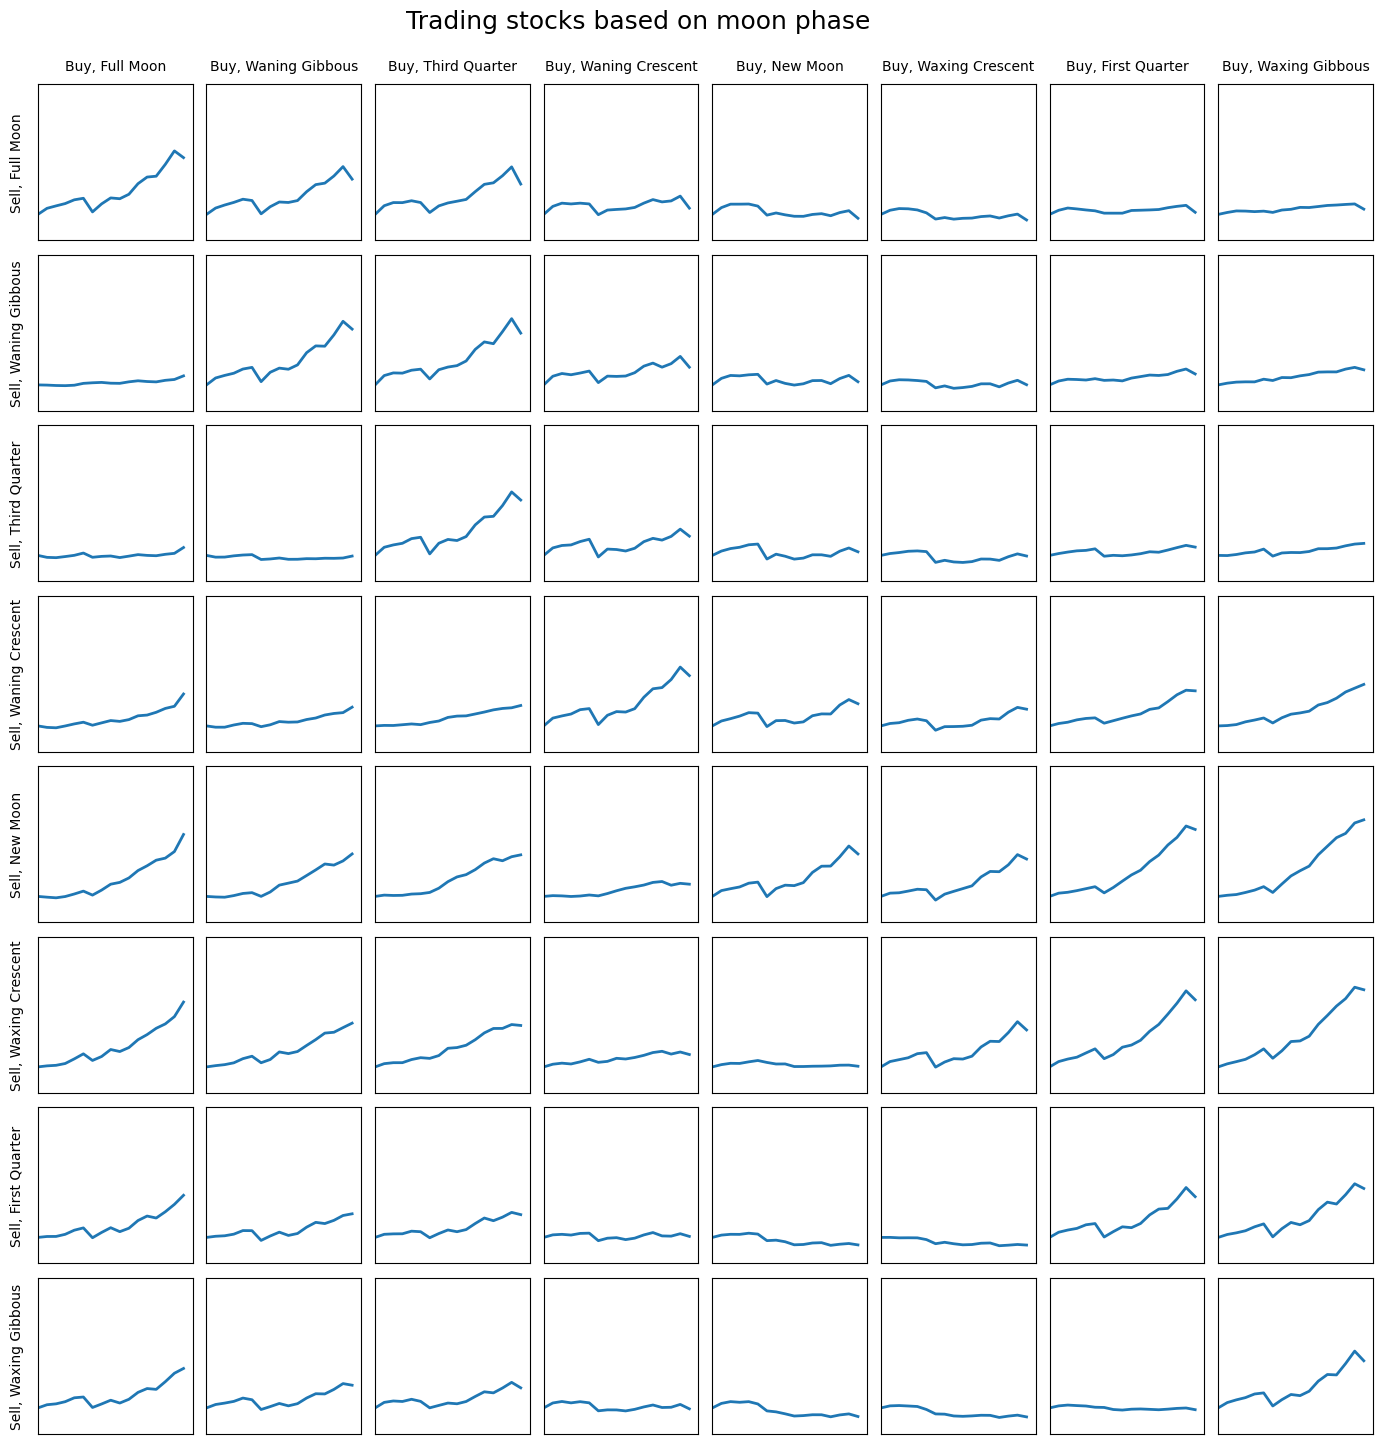

In [298]:
moon_phase_buy = np.arange(8)  # Replace with your 8 x1 values
moon_phase_sell = np.arange(8)  # Replace with your 8 x2 values

# Create an 8x8 grid of subplots
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

# Loop over x1 and x2 values
for i, phase_sell in enumerate(moon_phase_buy):
    for j, phase_buy in enumerate(moon_phase_sell):
        ax = axes[i, j]

        start_year, end_year = 2003, 2019
        annual_portfolio = [1000]
        until = start_year
        while until != end_year:
            start_date = str(until) + '-01-01'
            end_date = str(until+1) + '-01-01'
            old_value = annual_portfolio[-1]
            new_value = moon_strat(start_date, end_date, old_value, phase_buy, phase_sell)
            annual_portfolio.append(new_value)
            until += 1
        
        # Example plot: Replace with your actual plotting logic
        ax.plot(annual_portfolio, linewidth = 2)
        ax.set_xlim([0, len(annual_portfolio)])
        ax.set_ylim([0, 6000])
        
        # Only set labels on the edges of the grid
        if j == 0:
            ax.set_ylabel(f'Sell, {phase_mappings[phase_sell]}', rotation=90, fontsize=10, labelpad=10)
        if i == 0:
            ax.set_title(f'Buy, {phase_mappings[phase_buy]}', fontsize=10, pad=10)

        # Hide ticks to clean up the plot
        ax.set_xticks([])
        ax.set_yticks([])

# Adjust layout to avoid overlap
plt.tight_layout()

# Adjust the space between the plots for better label visibility
plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05)

plt.suptitle('Trading stocks based on moon phase', fontsize=18, y=1)

# Show the plot
plt.show()

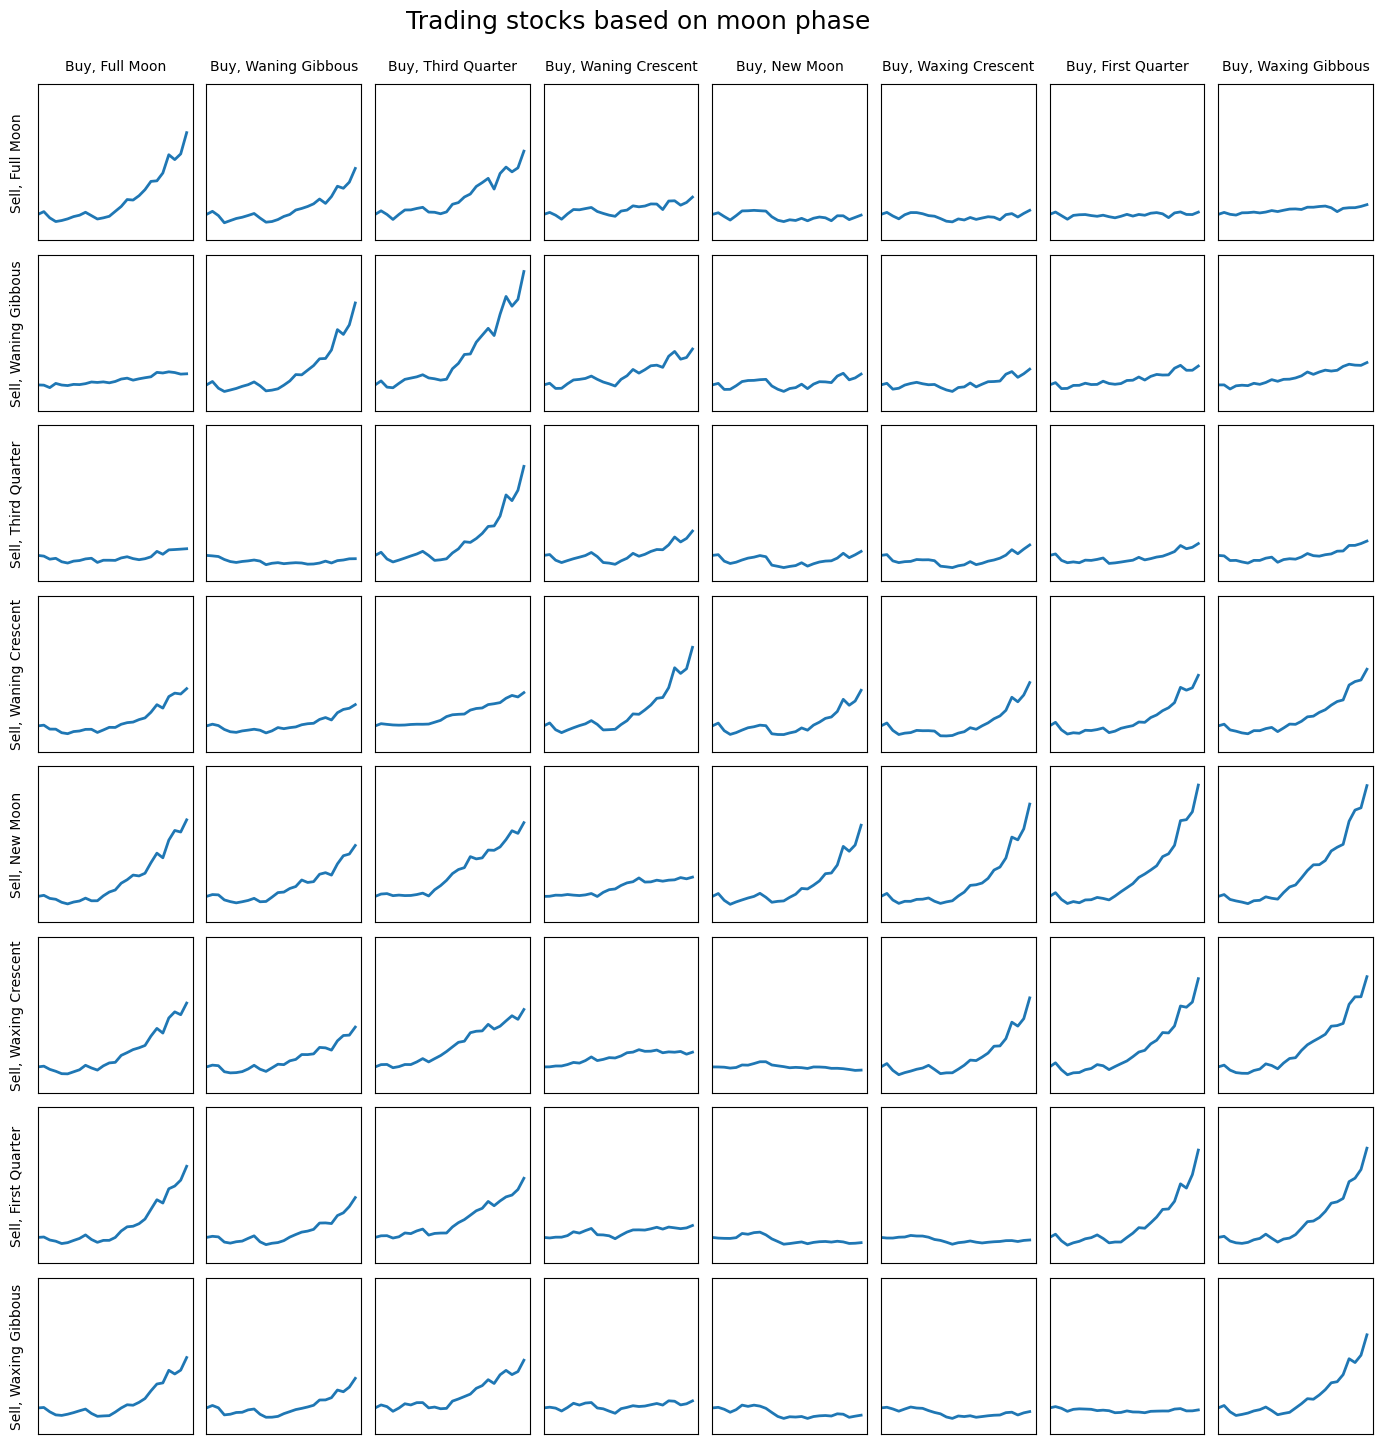

In [299]:
moon_phase_buy = np.arange(8)  # Replace with your 8 x1 values
moon_phase_sell = np.arange(8)  # Replace with your 8 x2 values

# Create an 8x8 grid of subplots
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

# Loop over x1 and x2 values
for i, phase_sell in enumerate(moon_phase_buy):
    for j, phase_buy in enumerate(moon_phase_sell):
        ax = axes[i, j]

        start_year, end_year = 1999, 2024
        annual_portfolio = [1000]
        until = start_year
        while until != end_year:
            start_date = str(until) + '-08-21'
            end_date = str(until+1) + '-08-21'
            old_value = annual_portfolio[-1]
            new_value = moon_strat(start_date, end_date, old_value, phase_buy, phase_sell)
            annual_portfolio.append(new_value)
            until += 1
        
        # Example plot: Replace with your actual plotting logic
        ax.plot(annual_portfolio, linewidth = 2)
        ax.set_xlim([0, len(annual_portfolio)])
        ax.set_ylim([0, 6000])
        
        # Only set labels on the edges of the grid
        if j == 0:
            ax.set_ylabel(f'Sell, {phase_mappings[phase_sell]}', rotation=90, fontsize=10, labelpad=10)
        if i == 0:
            ax.set_title(f'Buy, {phase_mappings[phase_buy]}', fontsize=10, pad=10)

        # Hide ticks to clean up the plot
        ax.set_xticks([])
        ax.set_yticks([])

# Adjust layout to avoid overlap
plt.tight_layout()

# Adjust the space between the plots for better label visibility
plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05)

plt.suptitle('Trading stocks based on moon phase', fontsize=18, y=1)

# Show the plot
plt.show()